Detailed spectra of astrophysical objects sometimes allow for determinations of how much of the gas is moving with a certain velocity along the line of sight, thanks to Doppler shifting of spectral lines. This enables "data cubes" to be created in RA, Dec, and line-of-sight velocity space. In yt, we can use the `PPVCube` analysis module to project fields along a given line of sight traveling at different line-of-sight velocities, to "mock-up" what would be seen in observations.

In [1]:
from yt.config import ytcfg

import yt
import numpy as np
from yt.extensions.astro_analysis.ppv_cube.api import PPVCube
import yt.units as u

To demonstrate this functionality, we'll create a simple unigrid dataset from scratch of a rotating disk. We create a thin disk in the x-y midplane of the domain of three cells in height in either direction, and a radius of 10 kpc. The density and azimuthal velocity profiles of the disk as a function of radius will be given by the following functions:

Density: $\rho(r) \propto r^{\alpha}$

Velocity: $v_{\theta}(r) \propto \frac{r}{1+(r/r_0)^{\beta}}$

where for simplicity we won't worry about the normalizations of these profiles. 

First, we'll set up the grid and the parameters of the profiles:

In [2]:
# increasing the resolution will make the images in this notebook more visually appealing
nx,ny,nz = (64, 64, 64) # domain dimensions
R = 10. # outer radius of disk, kpc
r_0 = 3. # scale radius, kpc
beta = 1.4 # for the tangential velocity profile
alpha = -1. # for the radial density profile
x, y = np.mgrid[-R:R:nx*1j,-R:R:ny*1j] # cartesian coordinates of x-y plane of disk
r = np.sqrt(x*x+y*y) # polar coordinates
theta = np.arctan2(y, x) # polar coordinates

Second, we'll construct the data arrays for the density, temperature, and velocity of the disk. Since we have the tangential velocity profile, we have to use the polar coordinates we derived earlier to compute `velx` and `vely`. Everywhere outside the disk, all fields are set to zero.  

In [3]:
dens = np.zeros((nx,ny,nz))
dens[:,:,nz//2-3:nz//2+3] = (r**alpha).reshape(nx,ny,1) # the density profile of the disk
temp = np.zeros((nx,ny,nz))
temp[:,:,nz//2-3:nz//2+3] = 1.0e5 # Isothermal
vel_theta = 100.*r/(1.+(r/r_0)**beta) # the azimuthal velocity profile of the disk
velx = np.zeros((nx,ny,nz))
vely = np.zeros((nx,ny,nz))
velx[:,:,nz//2-3:nz//2+3] = (-vel_theta*np.sin(theta)).reshape(nx,ny,1) # convert polar to cartesian
vely[:,:,nz//2-3:nz//2+3] = (vel_theta*np.cos(theta)).reshape(nx,ny,1) # convert polar to cartesian
dens[r > R] = 0.0
temp[r > R] = 0.0
velx[r > R] = 0.0
vely[r > R] = 0.0

Finally, we'll package these data arrays up into a dictionary, which will then be shipped off to `load_uniform_grid`. We'll define the width of the grid to be `2*R` kpc, which will be equal to 1  `code_length`. 

In [4]:
data = {}
data["density"] = (dens,"g/cm**3")
data["temperature"] = (temp, "K")
data["velocity_x"] = (velx, "km/s")
data["velocity_y"] = (vely, "km/s")
data["velocity_z"] = (np.zeros((nx,ny,nz)), "km/s") # zero velocity in the z-direction
bbox = np.array([[-0.5,0.5],[-0.5,0.5],[-0.5,0.5]]) # bbox of width 1 on a side with center (0,0,0)
ds = yt.load_uniform_grid(data, (nx,ny,nz), length_unit=(2*R,"kpc"), nprocs=1, bbox=bbox)

yt : [INFO     ] 2019-06-18 22:07:11,163 Parameters: current_time              = 0.0
yt : [INFO     ] 2019-06-18 22:07:11,164 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2019-06-18 22:07:11,165 Parameters: domain_left_edge          = [-0.5 -0.5 -0.5]
yt : [INFO     ] 2019-06-18 22:07:11,167 Parameters: domain_right_edge         = [0.5 0.5 0.5]
yt : [INFO     ] 2019-06-18 22:07:11,168 Parameters: cosmological_simulation   = 0.0


To get a sense of what the data looks like, we'll take a slice through the middle of the disk:

In [5]:
slc = yt.SlicePlot(ds, "z", ["density","velocity_x","velocity_y","velocity_magnitude"])

yt : [INFO     ] 2019-06-18 22:07:11,594 xlim = -0.500000 0.500000
yt : [INFO     ] 2019-06-18 22:07:11,594 ylim = -0.500000 0.500000
yt : [INFO     ] 2019-06-18 22:07:11,595 xlim = -0.500000 0.500000
yt : [INFO     ] 2019-06-18 22:07:11,596 ylim = -0.500000 0.500000
yt : [INFO     ] 2019-06-18 22:07:11,603 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2019-06-18 22:07:11,618 Making a fixed resolution buffer of (('gas', 'velocity_x')) 800 by 800
yt : [INFO     ] 2019-06-18 22:07:11,629 Making a fixed resolution buffer of (('gas', 'velocity_y')) 800 by 800
yt : [INFO     ] 2019-06-18 22:07:11,641 Making a fixed resolution buffer of (('gas', 'velocity_magnitude')) 800 by 800
yt : [WARNING  ] 2019-06-18 22:07:12,283 Plot image for field ('gas', 'velocity_y') has both positive and negative values. Min = -16485822.496296, Max = 16485822.496297.
yt : [WARNING  ] 2019-06-18 22:07:12,284 Switching to symlog colorbar scaling unless linear scaling is specif


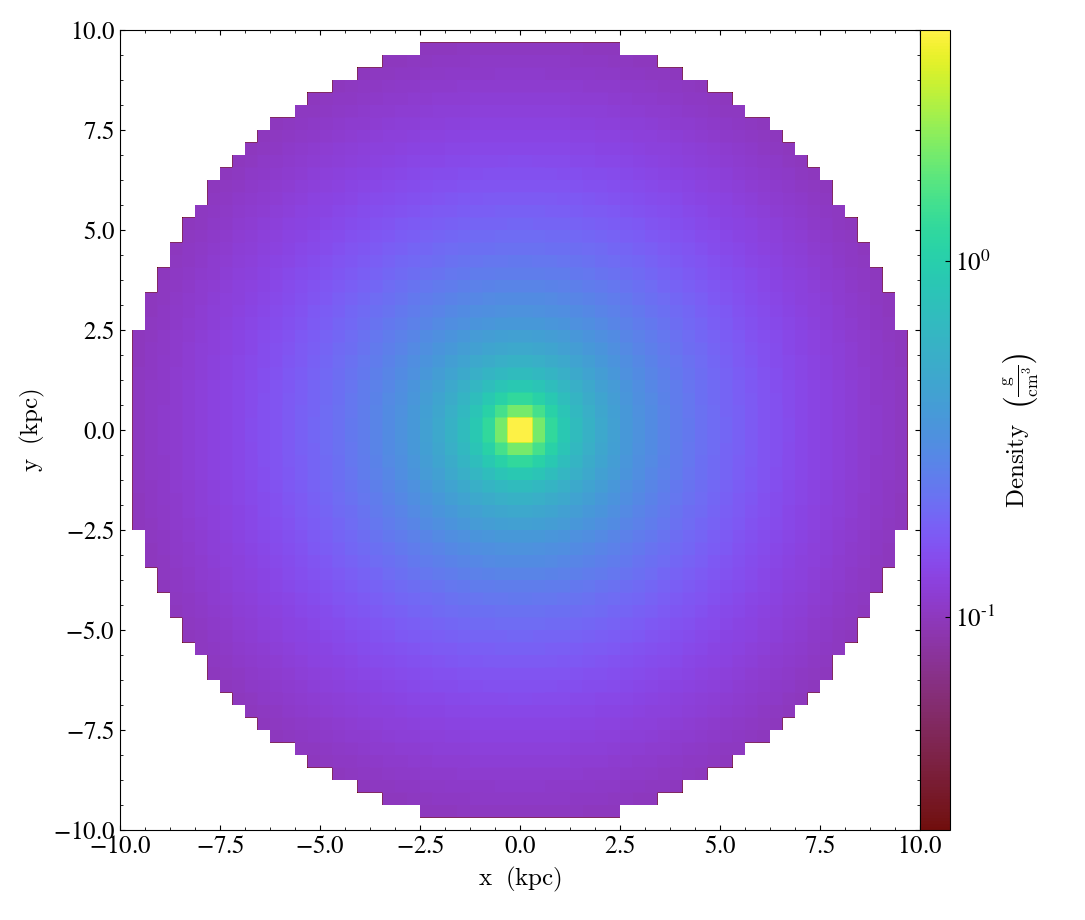
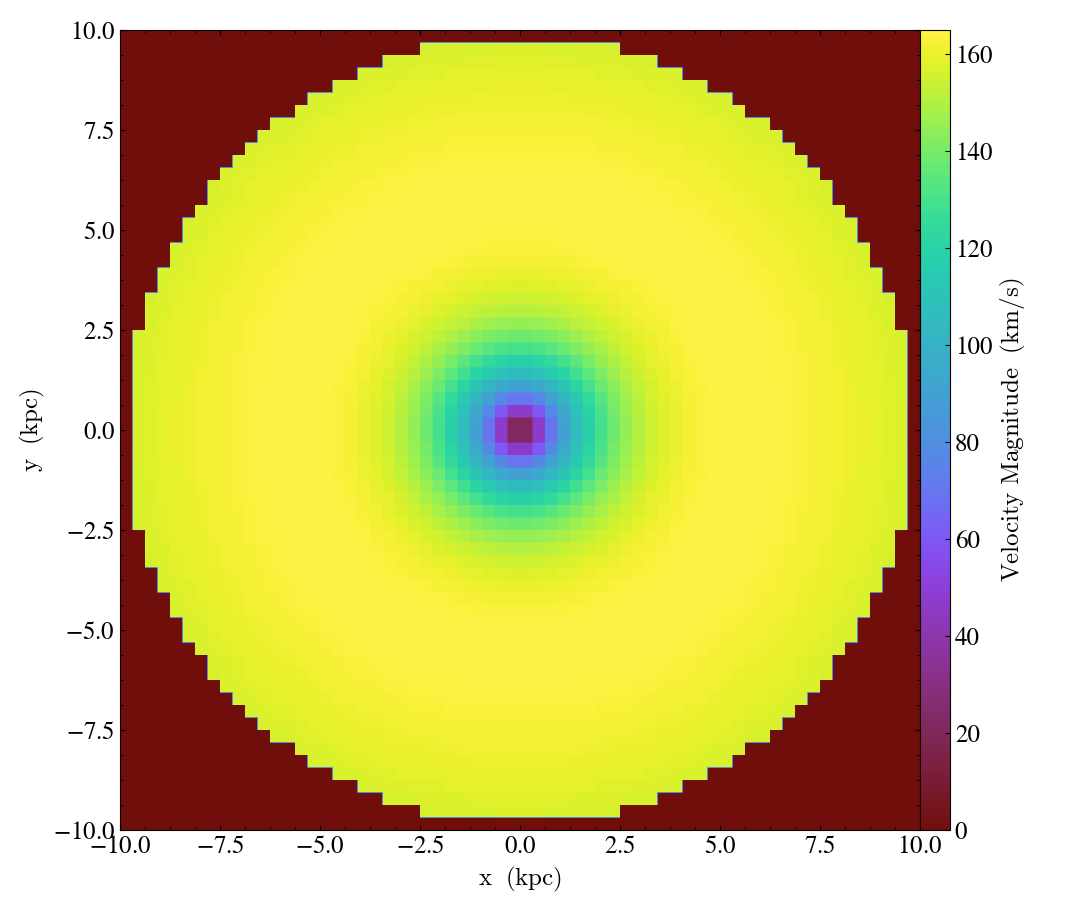
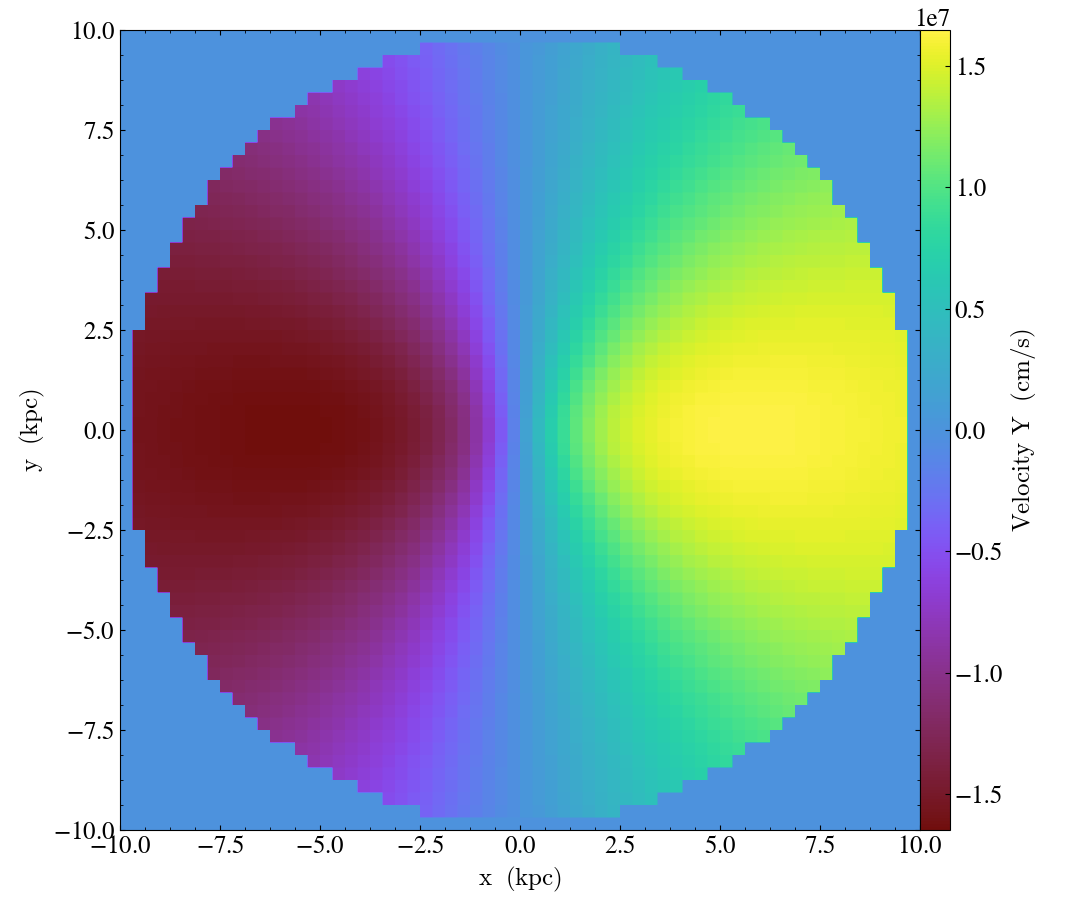
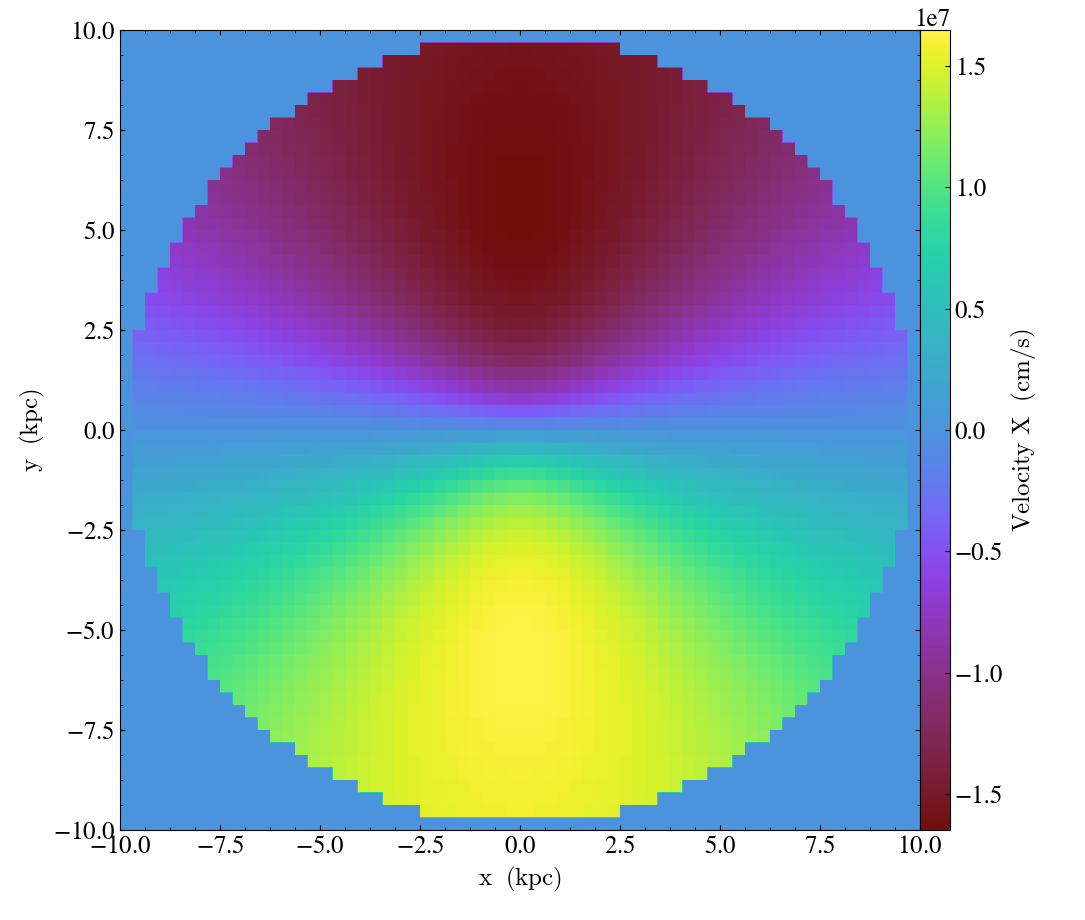

In [6]:
slc.set_log("velocity_x", False)
slc.set_log("velocity_y", False)
slc.set_log("velocity_magnitude", False)
slc.set_unit("velocity_magnitude", "km/s")
slc.show()

Which shows a rotating disk with a specific density and velocity profile. Now, suppose we wanted to look at this disk galaxy from a certain orientation angle, and simulate a 3D FITS data cube where we can see the gas that is emitting at different velocities along the line of sight. We can do this using the `PPVCube` class. First, let's assume we rotate our viewing angle 60 degrees from face-on, from along the z-axis into the x-axis. We'll create a normal vector:

In [7]:
i = 60.*np.pi/180.
L = [np.sin(i),0.0,np.cos(i)]

Next, we need to specify a field that will serve as the "intensity" of the emission that we see. For simplicity, we'll simply choose the gas density as this field, though it could be any field (including derived fields) in principle. We also need to choose the bounds in line-of-sight velocity that the data will be binned into, which is a 4-tuple in the shape of `(vmin, vmax, nbins, units)`, which specifies a linear range of `nbins` velocity bins from `vmin` to `vmax` in units of `units`. We may also optionally specify the dimensions of the data cube with the `dims` argument.

In [8]:
cube = PPVCube(ds, L, "density", (-150.,150.,50,"km/s"), dims=200, method="sum")

Generating cube: 100%|██████████| 50/50 [00:03<00:00, 15.84it/s]


Following this, we can now write this cube to a FITS file. The x and y axes of the file can be in length units, which can be optionally specified by `length_unit`:

In [9]:
cube.write_fits("cube.fits", overwrite=True, length_unit="kpc")

yt : [INFO     ] 2019-06-18 22:07:17,619 Making a FITS image of field density


Or one can use the `sky_scale` and `sky_center` keywords to set up the coordinates in RA and Dec:

In [10]:
sky_scale = (1.0, "arcsec/kpc")
sky_center = (30., 45.) # RA, Dec in degrees
cube.write_fits("cube_sky.fits", overwrite=True, sky_scale=sky_scale, sky_center=sky_center)

yt : [INFO     ] 2019-06-18 22:07:17,937 Making a FITS image of field density


Now, we'll look at the FITS dataset in yt and look at different slices along the velocity axis, which is the "z" axis:

In [11]:
ds_cube = yt.load("cube.fits")

yt : [INFO     ] 2019-06-18 22:07:18,257 Detected these axes: LINEAR LINEAR VOPT 
yt : [INFO     ] 2019-06-18 22:07:18,264 Found length units of kpc.
yt : [WARNING  ] 2019-06-18 22:07:18,266 Assuming 1.0 = 1.0 s
yt : [WARNING  ] 2019-06-18 22:07:18,266 Assuming 1.0 = 1.0 g
yt : [INFO     ] 2019-06-18 22:07:18,281 Parameters: current_time              = 0.0
yt : [INFO     ] 2019-06-18 22:07:18,281 Parameters: domain_dimensions         = [200 200  50]
yt : [INFO     ] 2019-06-18 22:07:18,282 Parameters: domain_left_edge          = [0.5 0.5 0.5]
yt : [INFO     ] 2019-06-18 22:07:18,283 Parameters: domain_right_edge         = [200.5 200.5  50.5]
yt : [INFO     ] 2019-06-18 22:07:18,283 Parameters: cosmological_simulation   = 0.0


yt : [INFO     ] 2019-06-18 22:07:18,292 Adding field density to the list of fields.
yt : [INFO     ] 2019-06-18 22:07:18,428 xlim = 0.500000 200.500000
yt : [INFO     ] 2019-06-18 22:07:18,429 ylim = 0.500000 200.500000
yt : [INFO     ] 2019-06-18 22:07:18,431 xlim = 0.500000 200.500000
yt : [INFO     ] 2019-06-18 22:07:18,431 ylim = 0.500000 200.500000
yt : [INFO     ] 2019-06-18 22:07:18,435 Making a fixed resolution buffer of (('fits', 'density')) 800 by 800



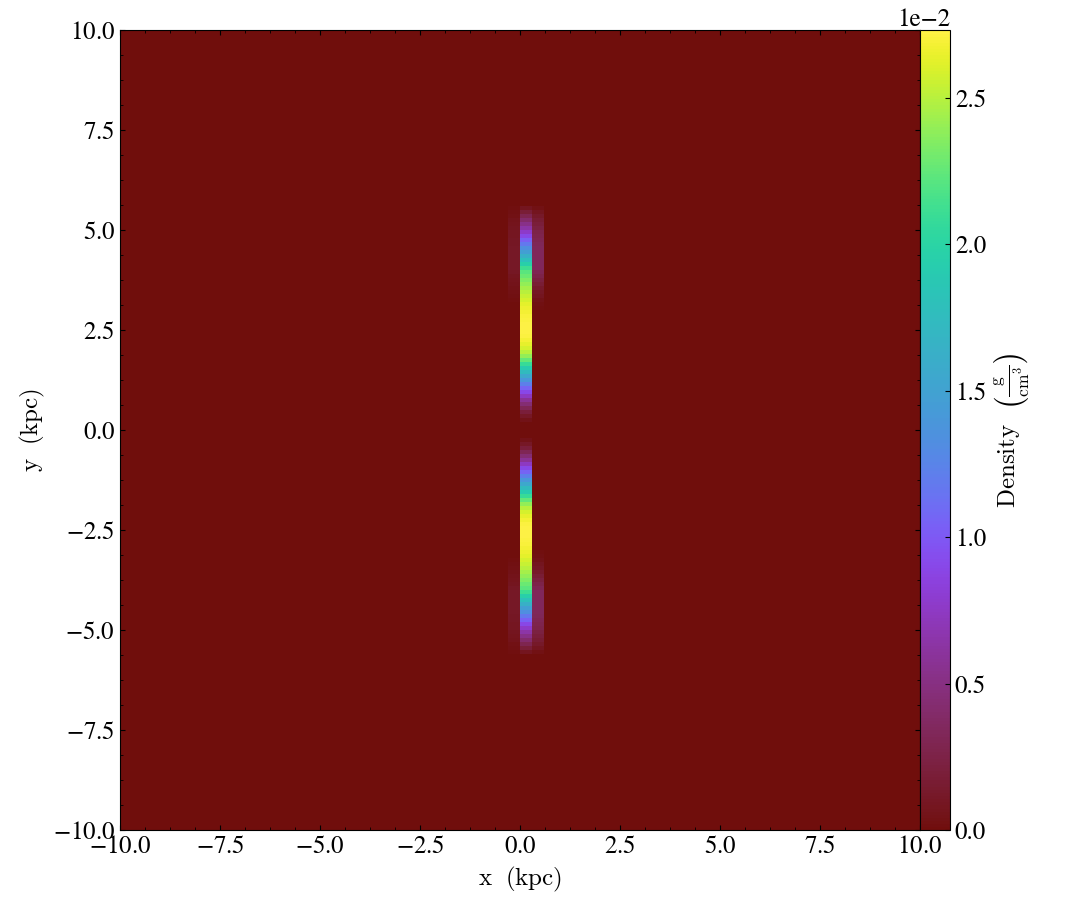

In [12]:
# Specifying no center gives us the center slice
slc = yt.SlicePlot(ds_cube, "z", ["density"])
slc.show()

yt : [INFO     ] 2019-06-18 22:07:18,876 xlim = 0.500000 200.500000
yt : [INFO     ] 2019-06-18 22:07:18,876 ylim = 0.500000 200.500000
yt : [INFO     ] 2019-06-18 22:07:18,877 xlim = 0.500000 200.500000
yt : [INFO     ] 2019-06-18 22:07:18,878 ylim = 0.500000 200.500000
yt : [INFO     ] 2019-06-18 22:07:18,879 Making a fixed resolution buffer of (('fits', 'density')) 800 by 800



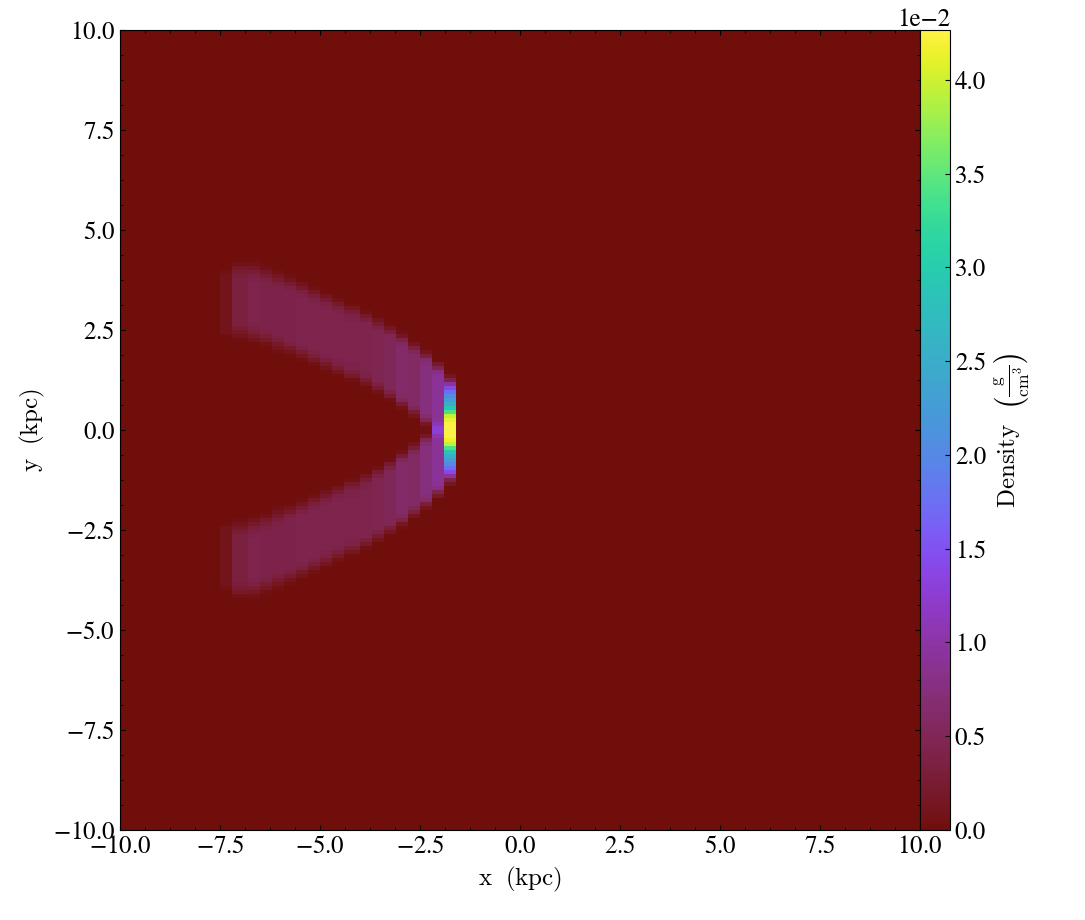

In [13]:
# Picking different velocities for the slices
new_center = ds_cube.domain_center
new_center[2] = ds_cube.spec2pixel(-100.*u.km/u.s)
slc = yt.SlicePlot(ds_cube, "z", ["density"], center=new_center)
slc.show()

yt : [INFO     ] 2019-06-18 22:07:19,284 xlim = 0.500000 200.500000
yt : [INFO     ] 2019-06-18 22:07:19,284 ylim = 0.500000 200.500000
yt : [INFO     ] 2019-06-18 22:07:19,285 xlim = 0.500000 200.500000
yt : [INFO     ] 2019-06-18 22:07:19,286 ylim = 0.500000 200.500000
yt : [INFO     ] 2019-06-18 22:07:19,287 Making a fixed resolution buffer of (('fits', 'density')) 800 by 800



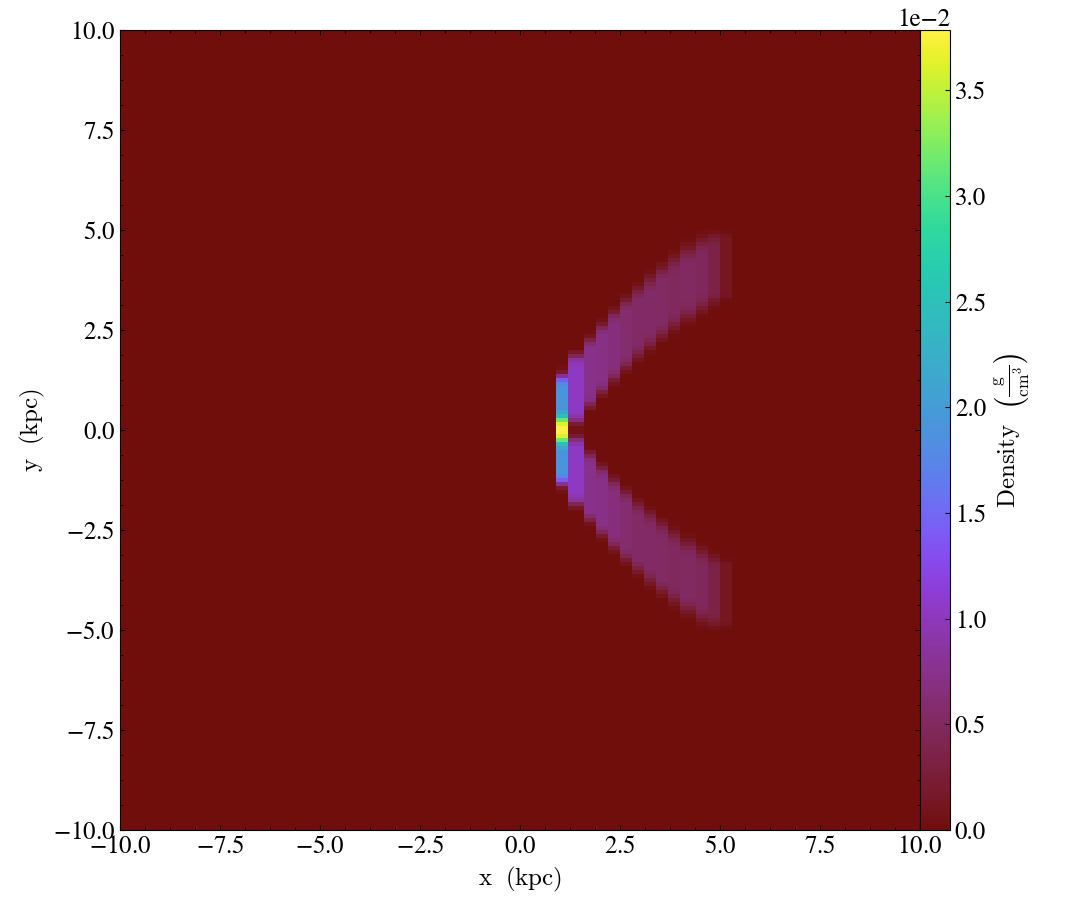

In [14]:
new_center[2] = ds_cube.spec2pixel(70.0*u.km/u.s)
slc = yt.SlicePlot(ds_cube, "z", ["density"], center=new_center)
slc.show()

yt : [INFO     ] 2019-06-18 22:07:19,797 xlim = 0.500000 200.500000
yt : [INFO     ] 2019-06-18 22:07:19,798 ylim = 0.500000 200.500000
yt : [INFO     ] 2019-06-18 22:07:19,798 xlim = 0.500000 200.500000
yt : [INFO     ] 2019-06-18 22:07:19,799 ylim = 0.500000 200.500000
yt : [INFO     ] 2019-06-18 22:07:19,800 Making a fixed resolution buffer of (('fits', 'density')) 800 by 800



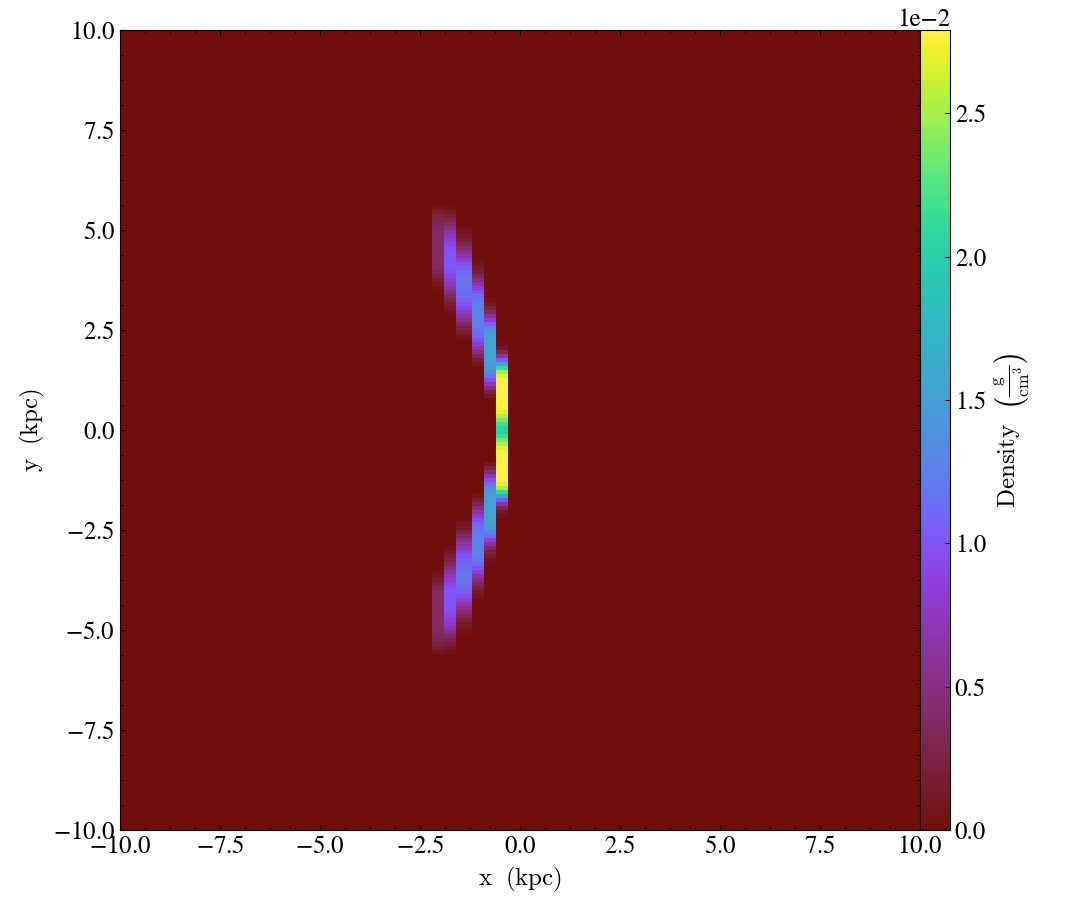

In [15]:
new_center[2] = ds_cube.spec2pixel(-30.0*u.km/u.s)
slc = yt.SlicePlot(ds_cube, "z", ["density"], center=new_center)
slc.show()

If we project all the emission at all the different velocities along the z-axis, we recover the entire disk:

yt : [INFO     ] 2019-06-18 22:07:20,375 Projection completed
yt : [INFO     ] 2019-06-18 22:07:20,376 xlim = 0.500000 200.500000
yt : [INFO     ] 2019-06-18 22:07:20,378 ylim = 0.500000 200.500000
yt : [INFO     ] 2019-06-18 22:07:20,379 xlim = 0.500000 200.500000
yt : [INFO     ] 2019-06-18 22:07:20,379 ylim = 0.500000 200.500000
yt : [INFO     ] 2019-06-18 22:07:20,382 Making a fixed resolution buffer of (('fits', 'density')) 800 by 800



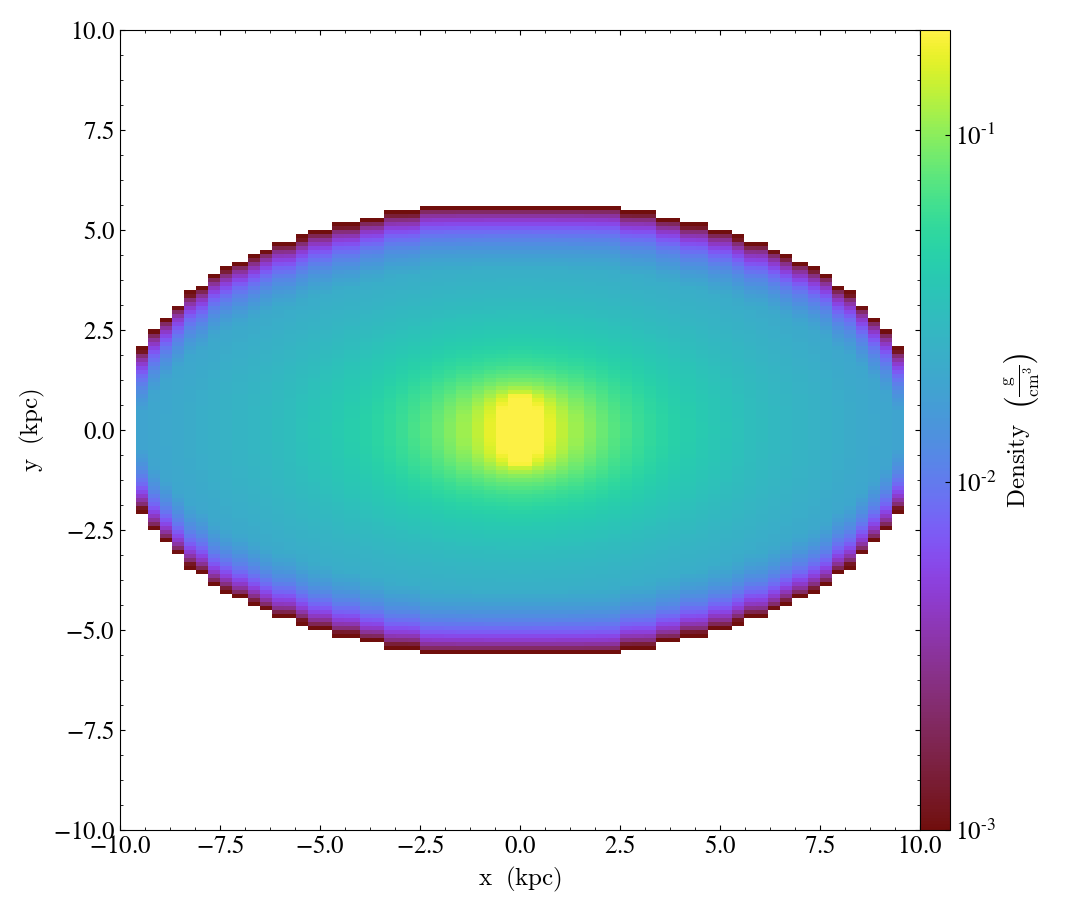

In [16]:
prj = yt.ProjectionPlot(ds_cube, "z", ["density"], method="sum")
prj.set_log("density", True)
prj.set_zlim("density", 1.0e-3, 0.2)
prj.show()

The `thermal_broad` keyword allows one to simulate thermal line broadening based on the temperature, and the `atomic_weight` argument is used to specify the atomic weight of the particle that is doing the emitting.

In [17]:
cube2 = PPVCube(ds, L, "density", (-150.,150.,50,"km/s"), dims=200, thermal_broad=True, 
                atomic_weight=12.0, method="sum")
cube2.write_fits("cube2.fits", overwrite=True, length_unit="kpc")

Generating cube: 100%|██████████| 50/50 [00:03<00:00, 13.71it/s]
yt : [INFO     ] 2019-06-18 22:07:24,608 Making a FITS image of field density


Taking a slice of this cube shows:

yt : [INFO     ] 2019-06-18 22:07:24,868 Detected these axes: LINEAR LINEAR VOPT 
yt : [INFO     ] 2019-06-18 22:07:24,874 Found length units of kpc.
yt : [WARNING  ] 2019-06-18 22:07:24,875 Assuming 1.0 = 1.0 s
yt : [WARNING  ] 2019-06-18 22:07:24,876 Assuming 1.0 = 1.0 g
yt : [INFO     ] 2019-06-18 22:07:24,888 Parameters: current_time              = 0.0
yt : [INFO     ] 2019-06-18 22:07:24,889 Parameters: domain_dimensions         = [200 200  50]
yt : [INFO     ] 2019-06-18 22:07:24,890 Parameters: domain_left_edge          = [0.5 0.5 0.5]
yt : [INFO     ] 2019-06-18 22:07:24,891 Parameters: domain_right_edge         = [200.5 200.5  50.5]
yt : [INFO     ] 2019-06-18 22:07:24,891 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-06-18 22:07:24,898 Adding field density to the list of fields.
yt : [INFO     ] 2019-06-18 22:07:25,095 xlim = 0.500000 200.500000
yt : [INFO     ] 2019-06-18 22:07:25,096 ylim = 0.500000 200.500000
yt : [INFO     ] 2019-06-18 22:07:25,097 xli


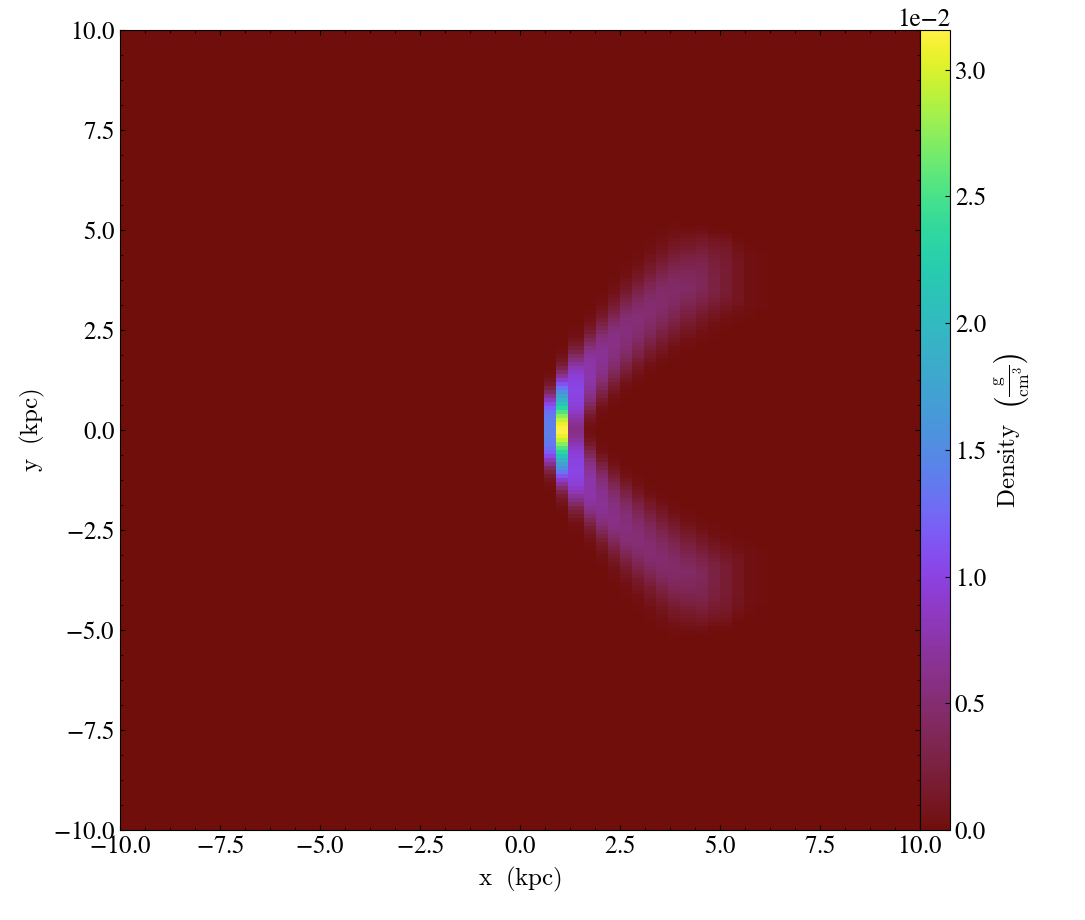

In [18]:
ds_cube2 = yt.load("cube2.fits")
new_center = ds_cube2.domain_center
new_center[2] = ds_cube2.spec2pixel(70.0*u.km/u.s)
slc = yt.SlicePlot(ds_cube2, "z", ["density"], center=new_center)
slc.show()

yt : [INFO     ] 2019-06-18 22:07:25,503 xlim = 0.500000 200.500000
yt : [INFO     ] 2019-06-18 22:07:25,504 ylim = 0.500000 200.500000
yt : [INFO     ] 2019-06-18 22:07:25,505 xlim = 0.500000 200.500000
yt : [INFO     ] 2019-06-18 22:07:25,505 ylim = 0.500000 200.500000
yt : [INFO     ] 2019-06-18 22:07:25,507 Making a fixed resolution buffer of (('fits', 'density')) 800 by 800



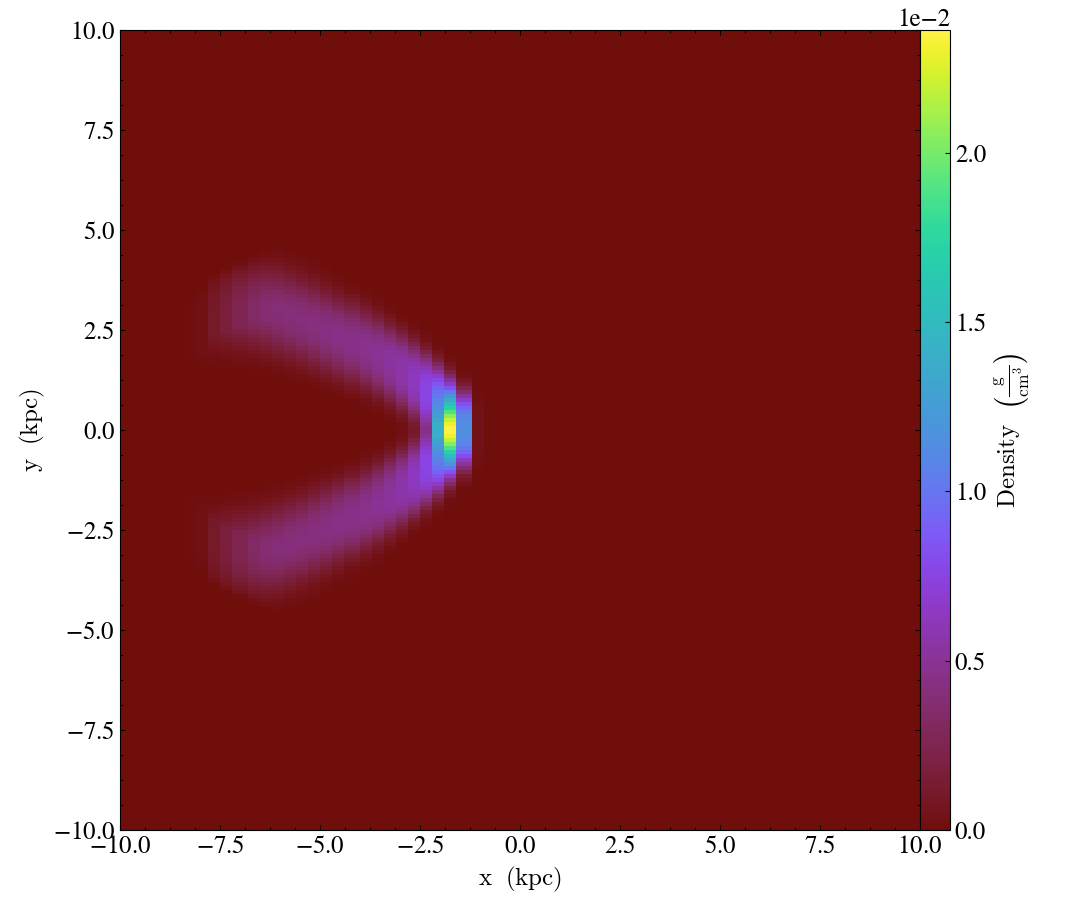

In [19]:
new_center[2] = ds_cube2.spec2pixel(-100.*u.km/u.s)
slc = yt.SlicePlot(ds_cube2, "z", ["density"], center=new_center)
slc.show()

where we can see the emission has been smeared into this velocity slice from neighboring slices due to the thermal broadening. 

Finally, the "velocity" or "spectral" axis of the cube can be changed to a different unit, such as wavelength, frequency, or energy: 

In [20]:
print (cube2.vbins[0], cube2.vbins[-1])
cube2.transform_spectral_axis(400.0,"nm")
print (cube2.vbins[0], cube2.vbins[-1])

-150.0 km/s 150.0 km/s
399.79996163130727 nm 400.20023864575296 nm


If a FITS file is now written from the cube, the spectral axis will be in the new units. To reset the spectral axis back to the original velocity units:

In [21]:
cube2.reset_spectral_axis()
print (cube2.vbins[0], cube2.vbins[-1])

-150.0 km/s 150.0 km/s
